## Интерпретация моделей и калибровка вероятностей

Будем тренироваться на примере задачи классификации оттоковых клиентов

In [150]:
# !pip install eli5 -q
# !pip install lime -q
# !pip install shap -q


In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import eli5, lime, shap

from catboost import CatBoostClassifier

Загрузим данные

In [152]:
data = pd.read_csv("https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/churn_clients.csv")

data.head()

,state,accountlength,areacode,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totaldaycharge,totaleveminutes,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalnightcharge,totalintlminutes,totalintlcalls,totalintlcharge,customerservicecalls,churn
0,KS,128,415,No,Yes,25,265.1,110.0,45.07,197.4,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123.0,27.47,195.5,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114.0,41.38,121.2,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71.0,50.90,61.9,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113.0,28.34,148.3,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3,False


Обработайте признаки:

* удалите категориальные признаки с больше, чем двумя различными значениями (обратите внимание, что `areacode` - также категориальный признак)

* бинарные признаки перведите в числа: True/Yes -> 1, False/No -> 0

In [153]:
category = ['internationalplan', 'voicemailplan', 'churn']
for i in category:
    data[i] = data[i].map({'Yes' : 1, 'No' : 0, True : 1, False : 0})

In [154]:
data = data.drop(['state', 'areacode'], axis=1)
data.head()

,accountlength,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totaldaycharge,totaleveminutes,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalnightcharge,totalintlminutes,totalintlcalls,totalintlcharge,customerservicecalls,churn
0,128,0,1,25,265.1,110.0,45.07,197.4,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.70,1,0
1,107,0,1,26,161.6,123.0,27.47,195.5,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1,0
2,137,0,0,0,243.4,114.0,41.38,121.2,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0,0
3,84,1,0,0,299.4,71.0,50.90,61.9,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2,0
4,75,1,0,0,166.7,113.0,28.34,148.3,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3,0


## Вопрос

Сколько колонок осталось в таблице data?

In [155]:
data.shape[1]

18

In [156]:
X = data.drop('churn', axis=1)
y = data['churn']

Разбейте данные на тренировочную и тестовую части. Размер тестовой части - 25%, `random_state=42`.

In [157]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

## Вопрос

Сколько строк в тренировочных данных?

In [158]:
Xtrain.shape[0]

2499

Обучите CatBoostClassifier с гиперпараметрами по умолчанию и `random_state=42` на тренировочных данных, сделайте прогноз на тестовых данных и вычислите значение ROC-AUC.

In [159]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

cat = CatBoostClassifier(random_state=42)
cat.fit(Xtrain, ytrain, verbose=0)
ypred_cat = cat.predict_proba(Xtest)[:,1]


## Вопрос

Чему равно значение ROC-AUC на тестовых данных? Ответ округлите до сотых.

In [160]:
from sklearn.metrics import roc_auc_score

roc_auc_score(ytest, ypred_cat).round(2)

0.94

Выведите на экран гистограмму важности признаков (стандартную, посчитанную на основе Information Gain)

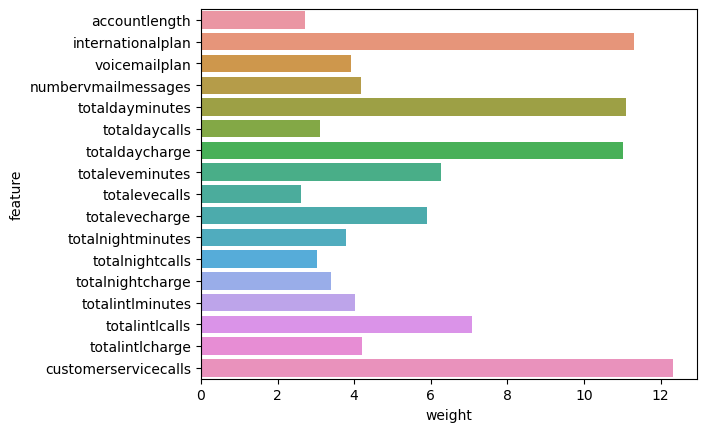

In [161]:
model_imps = pd.DataFrame({"feature": X.columns,
                        "weight": cat.feature_importances_})
sns.barplot(data=model_imps, y="feature", x="weight")
plt.show()

## Вопрос

Какой признак наиболее важен с точки зрения этого подхода?

Постройте гистограмму permutation importance по тренировочным данным

In [162]:
perm = eli5.sklearn.PermutationImportance(cat, random_state=42).fit(Xtrain, ytrain)
eli5.show_weights(perm, feature_names = Xtrain.columns.tolist())

Weight,Feature
0.0599 ± 0.0047,customerservicecalls
0.0545 ± 0.0053,totaldaycharge
0.0519 ± 0.0045,internationalplan
0.0502 ± 0.0065,totaldayminutes
0.0241 ± 0.0031,totalintlcalls
0.0211 ± 0.0012,totaleveminutes
0.0189 ± 0.0014,totalevecharge
0.0142 ± 0.0026,numbervmailmessages
0.0138 ± 0.0032,voicemailplan
0.0130 ± 0.0015,totalintlcharge


## Вопрос

Сколько признаков выделяет метод как наиболее важные? (темно-зеленый цвет на визуализации)

**Ответ:** 4 признака

Постройте гистограмму shap values по тестовым данным

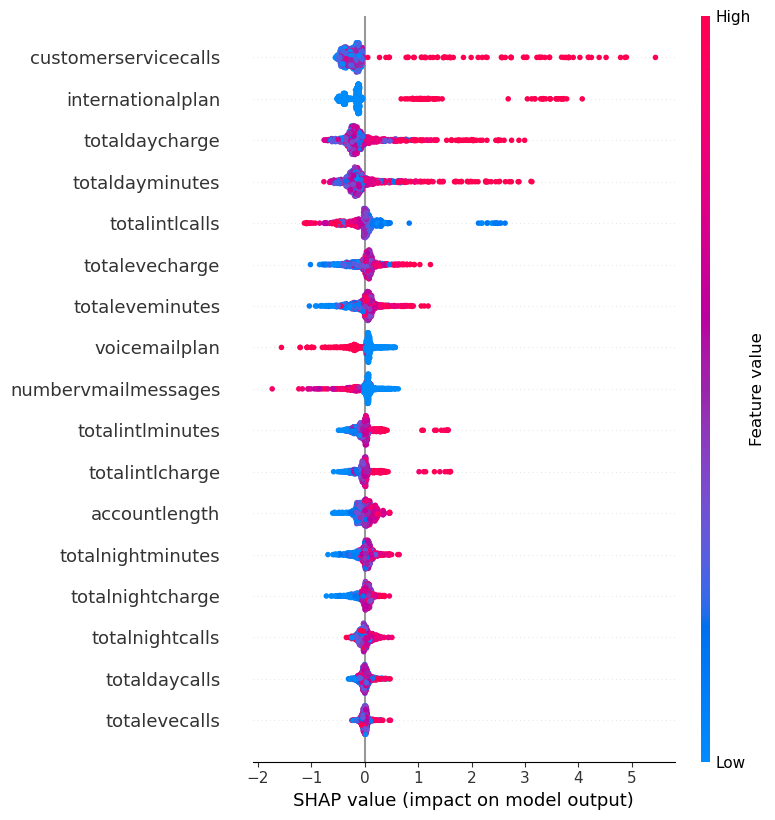

In [163]:
explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(Xtest)

shap.summary_plot(shap_values, Xtest)

## Вопрос

Какой признак наименее важен с точки зрения подхода SHAP?

**Ответ:** totalevecalls

Проинтерпретируем теперь индивидуальные прогнозы моделей

Проинтерпретируйте прогноз на тестовом объекте с индексом 5 методами:

* SHAP
* LIME

In [164]:
# Shap

shap.initjs()

print('Correct answer:', ytest.iloc[5])
shap.force_plot(explainer.expected_value, shap_values[5, :], Xtest.iloc[5, :])

Correct answer: 0


## Вопрос

Какой признак дает наибольший вклад в прогноз с точки зрения SHAP?

In [165]:
# your code here

In [166]:
#Lime
# lime.lime_tabular.LimeTabularExplainer
explainer = lime.lime_tabular.LimeTabularExplainer(Xtest.values, feature_names = Xtest.columns.values.tolist(), mode='regression')
explanation = explainer.explain_instance(Xtest.values[5], cat.predict, num_features=5 )

explanation.show_in_notebook(show_table=True)

## Вопрос

Какой признак дает наибольший вклад в прогноз с точки зрения метода LIME?

**Ответ:** internationalplan

## Калибровка вероятностей

Сделайте калибровку вероятностей с помощью методов 'sigmoid' и 'isotonic' при помощи CalibratedClassifierCV с `cv=2`.

Нарисуйте на одном графике исходную калибровочную кривую для CatBoost и две кривые после калибровки.

In [171]:
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from matplotlib.gridspec import GridSpec
from sklearn.metrics import brier_score_loss

cat_2 = CatBoostClassifier(random_state=42)

cat_isotonic = CalibratedClassifierCV(cat_2, method='isotonic', cv=2)
cat_sigmoid = CalibratedClassifierCV(cat_2, cv=2, method='sigmoid')

clf_list = [
    (cat, "Catboost"),
    (cat_isotonic, "Catboost + Isotonic"),
    (cat_sigmoid, "Catboost  + Sigmoid"),
]

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


Learning rate set to 0.015233
0:	learn: 0.6752635	total: 6.82ms	remaining: 6.81s
1:	learn: 0.6617820	total: 13.7ms	remaining: 6.84s
2:	learn: 0.6479005	total: 20.7ms	remaining: 6.88s
3:	learn: 0.6338435	total: 27.8ms	remaining: 6.93s
4:	learn: 0.6204428	total: 34.5ms	remaining: 6.87s
5:	learn: 0.6097648	total: 41ms	remaining: 6.79s
6:	learn: 0.5982691	total: 50.1ms	remaining: 7.11s
7:	learn: 0.5866627	total: 56.6ms	remaining: 7.02s
8:	learn: 0.5751202	total: 65.5ms	remaining: 7.21s
9:	learn: 0.5632503	total: 72ms	remaining: 7.13s
10:	learn: 0.5487198	total: 80.4ms	remaining: 7.23s
11:	learn: 0.5359360	total: 86.9ms	remaining: 7.16s
12:	learn: 0.5268862	total: 94.6ms	remaining: 7.18s
13:	learn: 0.5157269	total: 102ms	remaining: 7.16s
14:	learn: 0.5063566	total: 108ms	remaining: 7.08s
15:	learn: 0.4959042	total: 114ms	remaining: 6.99s
16:	learn: 0.4871783	total: 119ms	remaining: 6.88s
17:	learn: 0.4764523	total: 125ms	remaining: 6.83s
18:	learn: 0.4692380	total: 132ms	remaining: 6.82s
19

Text(0.5, 1.0, 'Calibration plot Catboost')

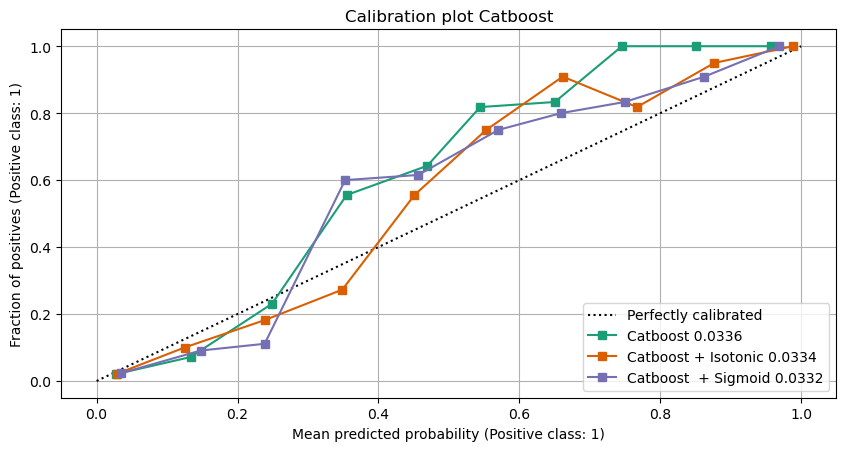

In [175]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap('Dark2')

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

for i, (clf, name) in enumerate(clf_list):
    clf.fit(Xtrain, ytrain)
    bs = np.round(brier_score_loss(ytest, clf.predict_proba(Xtest)[:, 1]), 4)
    
    
    display = CalibrationDisplay.from_estimator(
        clf,
        Xtest,
        ytest,
        n_bins=10,
        name = name + " " + str(bs),
        ax = ax_calibration_curve,
        color = colors(i),
    )
    calibration_displays[name] = display
    
    
ax_calibration_curve.grid()
ax_calibration_curve.set_title('Calibration plot Catboost')

Вычислим `brier_score` до калибровки

In [174]:
from sklearn.metrics import brier_score_loss

brier_score_loss(ytest, ypred_cat )

0.0335565178559375

## Вопрос

Вычислите `brier_score` после обеих калибровок.

В ответ запишите наименьшее из двух полученных значений, округленное до десятитысячных.

Ответ: 0.0332